### First we generate some simple synthetic data 

In this dataset, we'll have 5 covariates, and the outcome will simply be whether their sum is above the mean or not. However, we will also add informitive missingness to the first covariate, where missingness will only occur if the label is 1.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import sys
import fastsparsegams
sys.path.append(os.getcwd() + "/missingness-experiments")
sys.path.append(os.getcwd() + "/missingness-experiments/nature-mice-imputations")
from binarizer import Binarizer 
from visualization_utils import plot_shape_functions

# Generate data
n_rows = 1000
n_cols = 5
X = np.random.rand(n_rows, n_cols)
y = 1 * (np.sum(X, axis=1) > np.mean(np.sum(X, axis=1)))

# Add label-dependent missingness
mask_out_x1 = (y == 1) & (np.random.rand(n_rows) > 0.5)
X[mask_out_x1, 0] = np.nan

# Convert to a pandas dataframe
df = pd.DataFrame(X, columns=[f"x{i}" for i in range(n_cols)])
df['label'] = y

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=20, stratify=df.values[:, -1])

### Binarize and augment our input data

Next, we binarize our input data and add missingness indicators and interaction terms. The binarization function below returns versions of the dataset without augmentation, with missingness indicators only, and with missingness indicators and interactions. We'll work with the final of these.

In [7]:
num_quantiles = 3
label = df.columns[-1]

# Initialize our binarizer
encoder = Binarizer(quantiles = np.linspace(0, 1, num_quantiles + 2)[1:-1], label=label, 
                    miss_vals=[np.nan], 
                    overall_mi_intercept = False, overall_mi_ixn = False, 
                    specific_mi_intercept = True, specific_mi_ixn = True, 
                    numerical_cols = df.columns[:-1], 
                    categorical_cols= [])

# Generate our binarized and augmented data
(
    train_no, train_ind, train_aug, 
    test_no, test_ind, test_aug, 
    y_train_no, y_train_ind, y_train_aug, 
    y_test_no, y_test_ind, y_test_aug, 
    cluster_no, cluster_ind, cluster_aug
) = encoder.binarize_and_augment(
    train_df, test_df
)

### Finally, fit a model using fastsparsegams

In [14]:
# Using fastsparsegams, we can specify a grid of values for the L0 penalty;
# each of these will produce a distinct model, so we'll need to specify which one we
# want to work with later
lambda_grid = [[20, 15, 10, 7.5, 5, 4, 3, 2, 1.5, 1, 0.5, 0.1]]
model_aug = fastsparsegams.fit(
    train_aug.astype(float), y_train_aug.astype(int)*2 - 1, loss="Exponential", max_support_size=40, 
    algorithm="CDPSI", lambda_grid=lambda_grid, num_lambda=None, num_gamma=None
)

selected_lambda = model_aug.lambda_0[0][-1]

# Run our selected model over the train and test sets
# This model outputs probabilities, so we threshold them to binary predictions
preds = model_aug.predict(train_aug, selected_lambda) > 0.5
print(f"Train accuracy: {accuracy_score(preds, y_train_aug)}")

preds = model_aug.predict(test_aug, selected_lambda) > 0.5
print(f"Test accuracy: {accuracy_score(preds, y_test_aug)}")

Train accuracy: 0.95
Test accuracy: 0.93


### Visualize our model

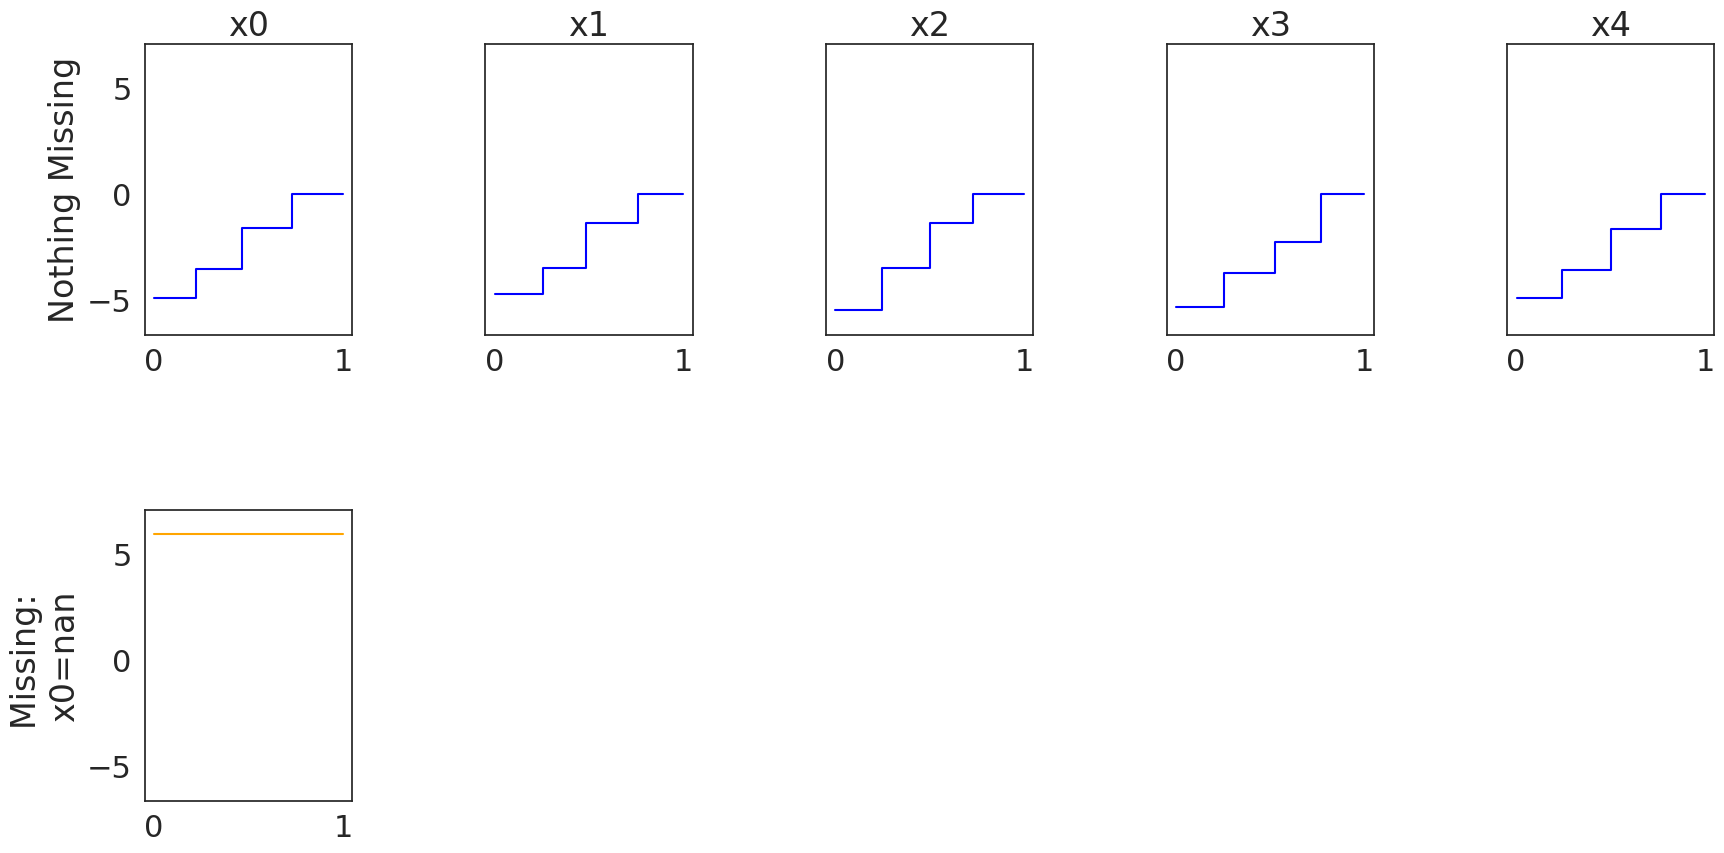

In [4]:
plot_shape_functions(
    train_df,
    encoder,
    model_aug, 
    selected_lambda,
    f'./gam_visualizations/tester_2.png'
)